In [2]:
import pandas as pd
import numpy as np
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
import umap
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn import metrics 
from scipy import stats

import sys
# sys.path.insert(0, '')
import importlib
from dredFISH.Analysis import basicu

importlib.reload(basicu)

sns.set_context('talk')

# Load data

In [3]:
f = '../data_dump/candidate_genes_vincent_0328.csv'
df0 = pd.read_csv(f)
df0 = df0.sort_values(['Subclass', 'Type/Gradient'])
df0 = df0[df0['Gene']!='Neurod1']
df0 = df0.set_index('Gene')
df0

,Subclass,Type/Gradient,Function,Priority,Note
Gene,,,,,
Baz1a,L2/3,A<B>C,TF,***,NaN
Trpc6,L2/3,A<B>C,IC,***,NaN
Bdnf,L2/3,A<B>C,CAM,***,NaN
Sox5,L2/3,A<B>C,TF,NaN,NaN
Nrp1,L2/3,A<B>C,CAM,***,NaN
...,...,...,...,...,...
Ngb,L2/3,NaN,other,NaN,NaN
Penk,L2/3,NaN,other,NaN,NaN
Chrm2,"L2/3, L4",C>B=A,IC,***,NaN


In [4]:
%%time
adata = ad.read('../data_dump/P38_glut_genes_v3_annot.h5ad')
adata

CPU times: user 163 ms, sys: 79.9 ms, total: 242 ms
Wall time: 240 ms


AnnData object with n_obs × n_vars = 5837 × 86
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'Doublet', 'Doublet Score', 'cluster', 'Class_broad', 'sample', 'Age', 'subclass', 'layer', 'Type', 'Subclass', 'embed_1', 'embed_2', 'PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5', 'PC_6', 'PC_7', 'PC_8', 'PC_9', 'PC_10', 'PC_11', 'PC_12', 'PC_13', 'PC_14', 'PC_15', 'PC_16', 'PC_17', 'PC_18', 'PC_19', 'PC_20', 'PC_21', 'PC_22', 'PC_23', 'PC_24', 'PC_25', 'PC_26', 'PC_27', 'PC_28', 'PC_29', 'PC_30', 'PC_31', 'PC_32', 'PC_33', 'PC_34', 'PC_35', 'PC_36', 'PC_37', 'PC_38', 'PC_39', 'PC_40', 'PC_41', 'PC_42', 'PC_43', 'PC_44', 'PC_45', 'PC_46', 'PC_47', 'PC_48', 'PC_49', 'PC_50', 'PC_51', 'PC_52', 'PC_53', 'PC_54', 'PC_55', 'PC_56', 'PC_57', 'PC_58', 'PC_59', 'PC_60', 'PC_61', 'PC_62', 'PC_63', 'PC_64', 'PC_65', 'PC_66', 'PC_67', 'PC_68', 'PC_69', 'PC_70', 'PC_71', 'PC_72', 'PC_73', 'PC_74', 'PC_75', 'PC_76', 'PC_77', 'PC_78', 'PC_79', 'PC_80', 'PC_81', 'PC_82', 'PC_83', 'PC_84', 'PC_8

In [5]:
# %%time
# # UMAP
# embed = umap.UMAP(n_components=2, random_state=0).fit_transform(adata.X)
# adata.obs['embed_1'] = embed[:,0]
# adata.obs['embed_2'] = embed[:,1]

# adata.write('../data_dump/P38_glut_genes_v3_annot.h5ad')

#  Utilities

In [6]:
def get_r2(y, yhat):
    """
    """
    r2 = 1-np.power(y-yhat, 2).sum()/np.power(y-np.mean(y), 2).sum()
    return r2

def get_mse(y, yhat):
    """
    """
    mse = np.power(y-yhat, 2).mean()
    return mse
    
def get_pearsonr(y, yhat):
    """
    """
    r, p = stats.pearsonr(y, yhat)
    return r

In [7]:
def regression_pipe(X, y, alpha):
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    
    ygs = np.empty(len(y))
    yps = np.empty(len(y))
    
    mse_s = []
    l0s = []
    l1s = []
    
    for train_idx, test_idx, in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # build model
        model = Lasso(alpha=alpha, random_state=0)
        # train
        model.fit(X_train, y_train)
        # test
        yp = model.predict(X_test)
        # evaluation
        mse = np.power(yp-y_test, 2).mean()
        l0 = (np.abs(model.coef_) > 1e-6).sum() 
        l1 = np.abs(model.coef_).sum()

        # add
        l0s.append(l0)
        l1s.append(l1)
        mse_s.append(mse)
        
        ygs[test_idx] = y_test
        yps[test_idx] = yp
    
    return ygs, yps, mse_s, l0s, l1s

def tuning_regression(X, y, alphas):
    """
    """
    res = []
    ressum = []
    for alpha in alphas:
        print(alpha)
        # run
        ygs, yps, mse_s, l0s, l1s = regression_pipe(X, y, alpha)
        res.append((ygs, yps, mse_s, l0s, l1s))
        ressum.append({
           'Reg Strength': alpha,
           'MSE': np.mean(mse_s),
           'r2': get_r2(ygs, yps),
           'coef L0': np.mean(l0s),
           'coef L1': np.mean(l1s),
          })
    
    ressum = pd.DataFrame(ressum)
    return res, ressum

def plot_regression_pipe(ax, ygs, ypgs, clusters, title="", legend=True):
    """
    """
    r2 = get_r2(ygs, yps)
    dfplot = pd.DataFrame()
    dfplot['Ground truth'] = ygs
    dfplot['Prediction'] = yps
    dfplot['Cluster'] = clusters 
    sns.scatterplot(data=dfplot, 
                    x='Ground truth',
                    y='Prediction',
                    hue='Cluster',
                    hue_order=np.sort(dfplot['Cluster'].unique()),
                    edgecolor='none',
                    s=5,
                    ax=ax,
                   )

    scale = min(max(ygs), max(yps))
    ax.plot([0, scale], [0, scale], color='k', linestyle='--')
    ax.set_title(f"{title}")
    ax.text(1, 0.1, f'r2={r2:.2f}', ha='right', transform=ax.transAxes)
    sns.despine(ax=ax)
    if legend:
        ax.legend(bbox_to_anchor=(1,1))
    else:
        ax.get_legend().remove()
    
def plot_ressum_reg(ressum, evalcol='AUPR', scale='linear', title=''):
    """
    """
    fig, axs = plt.subplots(2, 1, figsize=(5, 8), sharex=True)
    ax = axs[0]
    ax.plot(ressum['Reg Strength'], ressum['coef L0'], '-o')
    ax.set_ylabel('# genes used')
    ax.grid()
    sns.despine(ax=ax)
    ax.set_xscale(scale)
    ax.set_title(title)
    
    ax = axs[1]
    ax.plot(ressum['Reg Strength'], ressum[evalcol], '-o')
    ax.set_ylabel(evalcol)
    ax.set_xlabel('Regularization')
    ax.set_ylim(ymax=1.02)
    ax.grid()
    sns.despine(ax=ax)
    ax.set_xscale(scale)
    if scale == 'linear':
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-4,-4))
    
    plt.show()

# Regression example

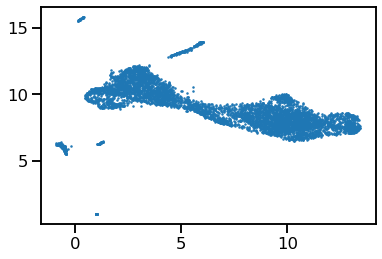

In [8]:
plt.scatter(adata.obs['embed_1'], 
            adata.obs['embed_2'],
            s=1,
           )

In [9]:
adata.X.shape

(5837, 86)

In [69]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import euclidean_distances
import igraph as ig
from scipy import sparse
import tqdm


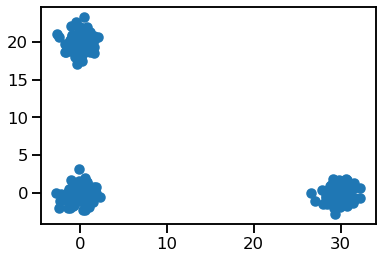

In [82]:
posX = np.vstack([
    np.random.randn(100,2),
    np.array([30,0]).reshape(1,-1)+np.random.randn(100,2),
    np.array([0,20]).reshape(1,-1)+np.random.randn(100,2),
])
N = len(posX)
                  
plt.scatter(posX[:,0], posX[:,1])

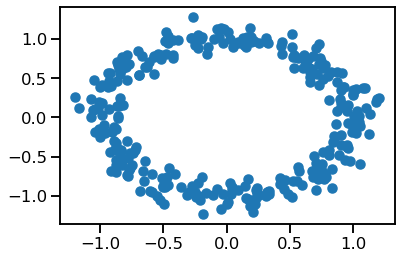

In [131]:
r = 1
r2 = 2
theta = np.linspace(0, 2*np.pi, 300)


posX2 = np.vstack([
    r*np.cos(theta)+0.1*np.random.randn(len(theta)), 
    r*np.sin(theta)+0.1*np.random.randn(len(theta)),
]).T


posX_tmp = np.vstack([
    r2*np.cos(theta)+0.1*np.random.randn(len(theta)), 
    r2*np.sin(theta)+0.1*np.random.randn(len(theta)),
]).T
posX2 = np.hstack(pso

N = len(posX2)
                  
plt.scatter(posX2[:,0], posX2[:,1])

In [83]:
pdists = euclidean_distances(posX)
pdists.shape, pdists.max()

((300, 300), 41.01155992885048)

In [88]:
%%time
# adj
res = []
dists = np.linspace(0, 30, 101)
print(dists)
for dist in tqdm.tqdm(dists):
    grh = ig.Graph.Adjacency((pdists<dist).astype(int))
    nmax = grh.clusters().giant().vcount()
    res.append(nmax)
    # print(dist, nmax, nmax/N)

[ 0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1  2.4  2.7  3.   3.3  3.6  3.9
  4.2  4.5  4.8  5.1  5.4  5.7  6.   6.3  6.6  6.9  7.2  7.5  7.8  8.1
  8.4  8.7  9.   9.3  9.6  9.9 10.2 10.5 10.8 11.1 11.4 11.7 12.  12.3
 12.6 12.9 13.2 13.5 13.8 14.1 14.4 14.7 15.  15.3 15.6 15.9 16.2 16.5
 16.8 17.1 17.4 17.7 18.  18.3 18.6 18.9 19.2 19.5 19.8 20.1 20.4 20.7
 21.  21.3 21.6 21.9 22.2 22.5 22.8 23.1 23.4 23.7 24.  24.3 24.6 24.9
 25.2 25.5 25.8 26.1 26.4 26.7 27.  27.3 27.6 27.9 28.2 28.5 28.8 29.1
 29.4 29.7 30. ]


100%|██████████| 101/101 [00:00<00:00, 174.08it/s]

CPU times: user 579 ms, sys: 15.7 ms, total: 595 ms
Wall time: 590 ms


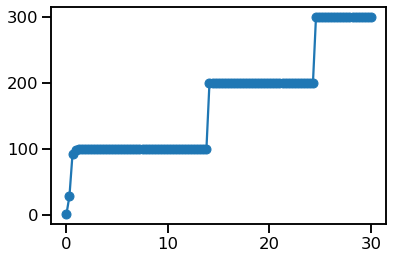

In [89]:
plt.plot(dists, np.array(res), '-o')
# plt.yscale('log')

In [108]:
def pipe(X, p=0.8, n=101, plow=0):
    """
    """
    res = []
    pdists = euclidean_distances(X)
    
    dists = np.linspace(pdists.max()*plow, pdists.max()*p, n)
    for dist in tqdm.tqdm(dists):
        grh = ig.Graph.Adjacency((pdists<dist).astype(int))
        nmax = grh.clusters().giant().vcount()
        res.append(nmax)
    res = np.array(res)
    return dists, res

100%|██████████| 101/101 [00:00<00:00, 148.49it/s]


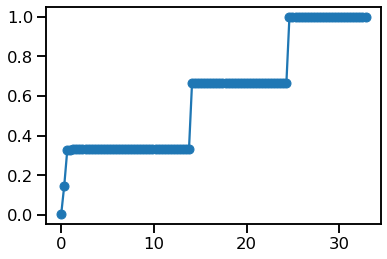

In [124]:
dists, res = pipe(posX)
plt.plot(dists, res/len(posX), '-o')

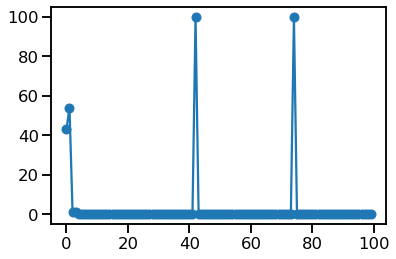

In [125]:
plt.plot(np.array(res[1:])-np.array(res[:-1]), '-o')

In [ ]:
X = adata.X
pcX = adata.obs.filter(regex="^PC").values[:,:6]
N = len(X)

100%|██████████| 10/10 [00:21<00:00,  2.11s/it]


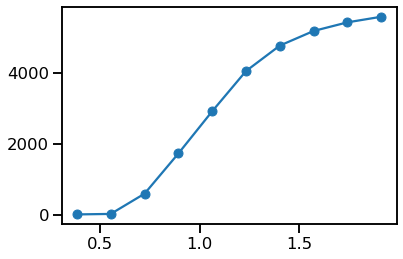

In [126]:
dists, res = pipe(pcX, p=0.1, plow=0.02, n=10)
plt.plot(dists, res, '-o')

100%|██████████| 30/30 [01:21<00:00,  2.72s/it]


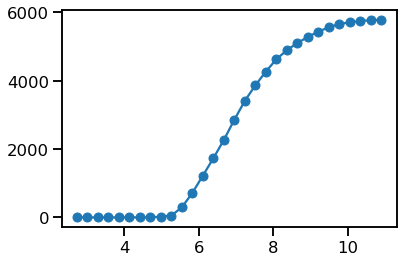

In [106]:
dists, res = pipe(X, p=0.4, plow=0.1, n=30)
plt.plot(dists, res, '-o')

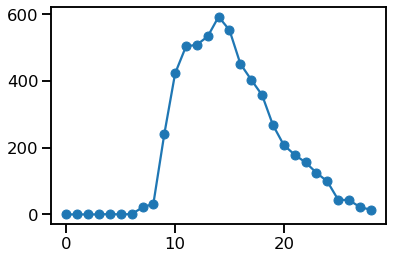

In [122]:
plt.plot(np.array(res[1:])-np.array(res[:-1]), '-o')

In [ ]:
# %%time
# # adj
# # distance 
# nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(pcX)
# gknn = nbrs.kneighbors_graph(mode='distance')
# gknn = gknn.tocoo()

# # perturbation
# res = []
# dists = np.linspace(1, 10, 21)
# print(dists)
# for dist in dists:
#     cond = gknn.data < dist
#     adj = sparse.coo_matrix(
#         ([1]*cond.sum(), (gknn.row[cond], gknn.col[cond])), 
#         shape=gknn.shape,
#     )
#     grh = ig.Graph.Adjacency(adj)
#     nmax = grh.clusters().giant().vcount()
#     res.append(nmax)
#     print(dist, nmax, nmax/N)

# visualization
# plt.plot(dists, np.array(res), '-o')
# # plt.yscale('log')